# Distributed DeepRacer RL training with SageMaker and RoboMaker

---
## Introduction


In this notebook, we will train a fully autonomous 1/18th scale race car using reinforcement learning using Amazon SageMaker RL and AWS RoboMaker's 3D driving simulator. [AWS RoboMaker](https://console.aws.amazon.com/robomaker/home#welcome) is a service that makes it easy for developers to develop, test, and deploy robotics applications.  

This notebook provides a jailbreak experience of [AWS DeepRacer](https://console.aws.amazon.com/deepracer/home#welcome), giving us more control over the training/simulation process and RL algorithm tuning.

![Training in Action](./deepracer-reinvent-track.jpg)


---
## How it works?  

![How training works](./training.png)

The reinforcement learning agent (i.e. our autonomous car) learns to drive by interacting with its environment, e.g., the track, by taking an action in a given state to maximize the expected reward. The agent learns the optimal plan of actions in training by trial-and-error through repeated episodes.  
  
The figure above shows an example of distributed RL training across SageMaker and two RoboMaker simulation envrionments that perform the **rollouts** - execute a fixed number of episodes using the current model or policy. The rollouts collect agent experiences (state-transition tuples) and share this data with SageMaker for training. SageMaker updates the model policy which is then used to execute the next sequence of rollouts. This training loop continues until the model converges, i.e. the car learns to drive and stops going off-track. More formally, we can define the problem in terms of the following:  

1. **Objective**: Learn to drive autonomously by staying close to the center of the track.
2. **Environment**: A 3D driving simulator hosted on AWS RoboMaker.
3. **State**: The driving POV image captured by the car's head camera, as shown in the illustration above.
4. **Action**: Six discrete steering wheel positions at different angles (configurable)
5. **Reward**: Positive reward for staying close to the center line; High penalty for going off-track. This is configurable and can be made more complex (for e.g. steering penalty can be added).

### Imports

To get started, we'll import the Python libraries we need, set up the environment with a few prerequisites for permissions and configurations.

You can run this notebook from your local machine or from a SageMaker notebook instance. In both of these scenarios, you can run the following to launch a training job on SageMaker and a simulation job on RoboMaker.

In [1]:
from src.core.DeepRacerEngine import DeepRacerEngine

### Scenario 1: Single Model Run and Evaluation

For this scenario, we are going to run a single model, over a chosen track

### Set Up Parameters
There are two set of parameters we can configure:
 - The simulation parameters
 - The model hyperparameters

#### View Default Simulation Parameters

In [2]:
!pygmentize common/constant.py

# Estimator Pamrs
entry_point = "training_worker.py"
source_dir = 'src'

#Training Params
default_instance_type = "ml.c4.2xlarge"
default_job_duration = 3600
default_hyperparam_preset = 'src/markov/presets/preset_hyperparams.json'
tmp_hyperparam_preset = 'src/markov/presets/preset_hyperparams_tmp.py'

#Track Details:
default_track_name = 'reinvent_base'
track_name = ['reinvent_base', 'reinvent_carpet', 'reinvent_concrete', 'reinvent_wood', 'AWS_track',
              'Bowtie_track', 'Oval_track',  'Straight_track']

# Evaluation Trials
evaluation_trials = 5

## Policy and Model Meta Data
envir_file_local = 'src/markov/environments/deepracer_racetrack_env.py'
reward_file_local = 'src/markov/rewards/complex_reward.py'
model_meta_file_local = 'src/markov/actions/model_metadata_10_state.json'
presets_file_local = 'src/markov/presets/preset_attention_layer-params.py'


#### View Default Hypterparameters

In [3]:
!pygmentize src/markov/presets/preset_hyperparams_tmp.py

learning_rate=0.0003
batch_size=256
optimizer_epsilon=1e-05
adam_optimizer_beta2=0.999
clip_likelihood_ratio_using_epsilon=0.2
beta_entropy=0.01
gae_lambda=0.95
discount=0.999
optimization_epochs=10


#### Set Parameters

In [2]:
#here we can set the params we want to use for our model runs
params = {
    'job_name': 'dr-test-f',
    'track_name':'reinvent_base',
    'job_duration': 300,
    'batch_size':256,
    'evaluation_trials':5
}

#### Instantiate the DeepRacerEngine class, and provide the params

In [3]:
deepRacer = DeepRacerEngine(params)

***Deep Racer Engine Backend***


#### Start Simulation Training 

In [ ]:
deepRacer.start_training_testing_process()

********************************
PERFORMING ALL DOCKER, VPC, AND ROUTING TABLE WORK....
Using s3 bucket sagemaker-us-east-1-170991494985
Model checkpoints and other metadata will be stored at: 
s3://sagemaker-us-east-1-170991494985/dr-test-f-sagemaker-191221-100752
Using Sagemaker IAM role arn: 
arn:aws:iam::170991494985:role/service-role/AmazonSageMaker-ExecutionRole-20191119T175598
Copying files from your notebook to existing sagemaker container
docker images sagemaker-docker-cpu | sed -n 2,2p
Sagemaker docker id : 2f46ad743d60
docker run -d -t 2f46ad743d60
docker exec -d 92c7088c7fedd224d438b735cb063b2dfc55923b6a0e3318b03a0722a2243d51 rm -rf /opt/amazon/markov
docker cp ./src/markov 92c7088c7fedd224d438b735cb063b2dfc55923b6a0e3318b03a0722a2243d51:/opt/amazon/markov
============ Copied Markov scripts to sagemaker docker ============ 
 
docker ps -l|sed -n 2,2p
docker commit 92c7088c7fed sagemaker-docker-cpu
============ Commited all the changes to docker ============ 
 
Using the Dee

#### Start Evaluation Proces


In [ ]:
deepRacer.start_model_evaluation()

Create local folder /tmp/dr-test-e-2019-12-21-09-40-21-156
Waiting for s3://sagemaker-us-east-1-170991494985/sagemaker-us-east-1-170991494985/training_metrics-dr-test-e-2019-12-21-09-40-21-156.json......

KeyboardInterrupt: 

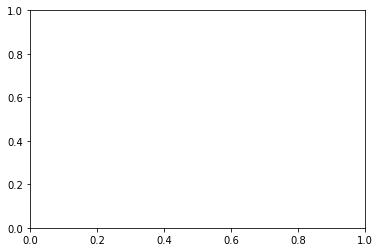

In [12]:
deepRacer.plot_training_output()